<a href="https://colab.research.google.com/github/Pavithrakumar19/outfit-reccomendation-system/blob/main/recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [ ]:
# Load the dataset
file_path = 'myntra.csv'
train_data = pd.read_csv(file_path)

In [ ]:
train_data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_id', 'link', 'size',
       'variant_sku', 'brand', 'care_instructions', 'dominant_material',
       'title', 'actual_color', 'dominant_color', 'product_type', 'images',
       'body', 'product_details', 'size_fit', 'complete_the_look', 'type',
       'variant_price', 'variant_compare_at_price', 'ideal_for', 'is_in_stock',
       'inventory', 'specifications', 'Unnamed: 25'],
      dtype='object')

In [ ]:
# Select and rename relevant columns
train_data = train_data[['uniq_id', 'product_id', 'brand', 'title', 'type', 'variant_price', 'inventory', 'specifications']]
train_data.head(3)

,uniq_id,product_id,brand,title,type,variant_price,inventory,specifications
0,cc51c3dd925d9d84e2fb28c7918dbbc3,6937673,IMARA,IMARA Women Black Solid Top,Clothing/Women/Tops/IMARA/More by IMARA,959,0,Transparency : Opaque | Sleeve Styling : Bell ...
1,c7e2fe388a93dae5c86b50dd8a5dbd7a,7441182,House of Pataudi,House of Pataudi Men Black Printed Straight Kurta,Clothing/Men/Kurtas/House of Pataudi/More by H...,799,Shape : Straight | Sleeve Styling : Regular Sl...,NaN
2,76949d78057a633aace6246045eefd66,9245141,The White Willow,The White Willow Unisex Off-White Therapedic M...,Home/Unisex/Pillows/The White Willow/More by T...,1399,Number of Components : 1 | Material : Polycott...,NaN


In [ ]:
train_data.isnull().sum()

,0
uniq_id,0
product_id,0
brand,0
title,0
type,0
variant_price,0
inventory,132
specifications,5379


In [ ]:
# Fill missing values with defaults
train_data['inventory'].fillna(0, inplace=True)
train_data['specifications'].fillna('', inplace=True)

In [ ]:
column_name_mapping = {
    'uniq_id': 'ID',
    'product_id': 'ProdID',
    'brand': 'Brand',
    'title': 'Name',
    'type': 'Category',
    'variant_price': 'Price',
    'inventory': 'Inventory',
    'specifications': 'Specifications'
}
train_data.rename(columns=column_name_mapping, inplace=True)


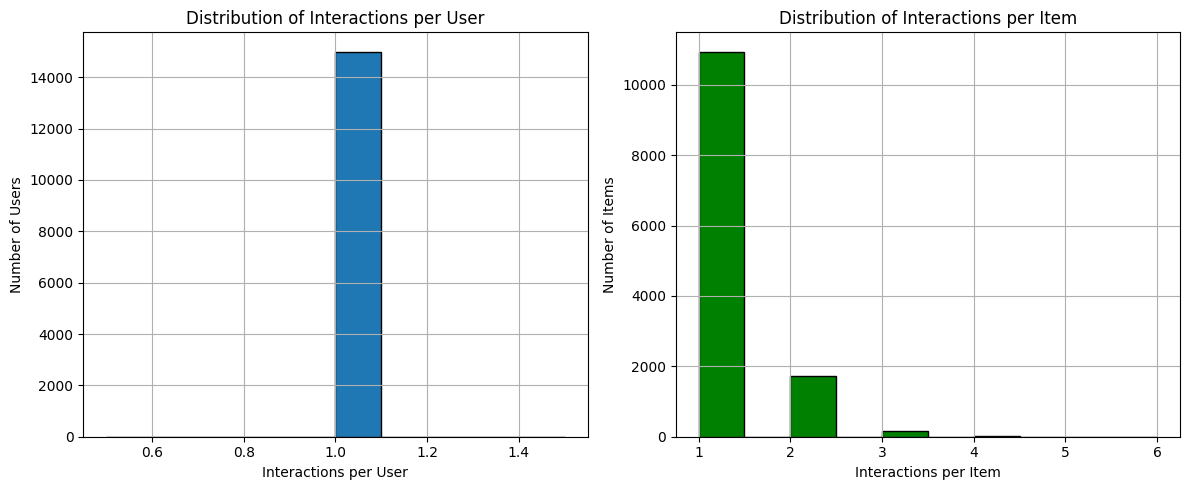

In [ ]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

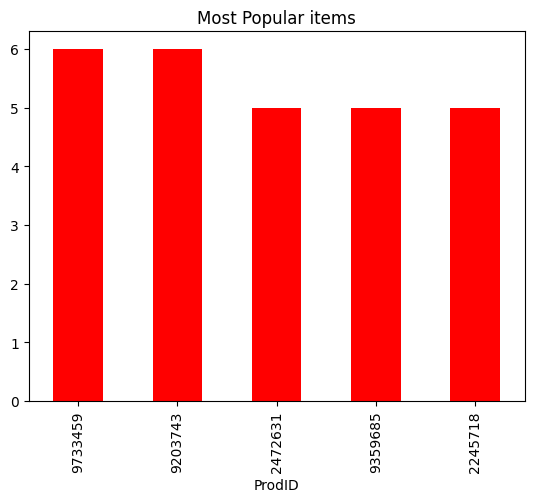

In [ ]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

In [ ]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Define function to clean and extract tags using NLTK
def clean_and_extract_tags_nltk(text):
    tokens = word_tokenize(text.lower())
    tags = [word for word in tokens if word.isalpha() and word not in stop_words and word not in punctuation]
    return ', '.join(tags)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Apply the tag extraction to relevant columns
columns_to_extract_tags_from = ['Brand', 'Name', 'Category']
for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags_nltk)

# Concatenate the cleaned tags into a single 'Tags' column
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)


In [ ]:
print(train_data['Tags'])

0            imara, imara, women, black, solid, top, imara
1        house, pataudi, house, pataudi, men, black, pr...
2        white, willow, white, willow, unisex, theraped...
3        dupatta, bazaar, dupatta, bazaar, pink, dupatt...
4        manyavar, manyavar, men, yellow, white, self, ...
                               ...                        
14995    lilpicks, lilpicks, boys, green, yellow, print...
14996    shakumbhari, shakumbhari, women, pink, embroid...
14997    anouk, anouk, women, green, floral, foil, prin...
14998    anouk, anouk, women, green, white, printed, st...
14999    rare, roots, rare, roots, women, navy, blue, s...
Name: Tags, Length: 15000, dtype: object


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [ ]:
print(train_data['Name'])

0                          imara, women, black, solid, top
1        house, pataudi, men, black, printed, straight,...
2        white, willow, unisex, therapedic, memory, foa...
3                           dupatta, bazaar, pink, dupatta
4        manyavar, men, yellow, white, self, design, ku...
                               ...                        
14995    lilpicks, boys, green, yellow, printed, kurta,...
14996         shakumbhari, women, pink, embroidered, kurta
14997    anouk, women, green, floral, foil, printed, ca...
14998    anouk, women, green, white, printed, straight,...
14999         rare, roots, women, navy, blue, solid, dress
Name: Name, Length: 15000, dtype: object


In [ ]:
item_name = 'imara, women, black, solid, top'
item_index = train_data[train_data['Name']==item_name].index[0]

In [ ]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]
train_data.iloc[recommended_items_indics][['Name','Brand']]

,Name,Brand
6194,"imara, women, black, solid, top",imara
11334,"imara, women, black, solid, top",imara
10670,"imara, women, black, solid, kurta",imara
13910,"imara, women, black, solid, kurta",imara
14447,"imara, women, black, solid, kurta",imara
14721,"imara, women, black, top",imara
9703,"imara, women, black, solid, straight, kurta",imara
14312,"imara, women, black, solid, straight, kurta",imara
5098,"imara, women, solid, top",imara


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'Brand']]

    return recommended_items_details

In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'imara, women, black, solid, top'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,Brand
6194,"imara, women, black, solid, top",imara
11334,"imara, women, black, solid, top",imara
10670,"imara, women, black, solid, kurta",imara
13910,"imara, women, black, solid, kurta",imara
14447,"imara, women, black, solid, kurta",imara
14721,"imara, women, black, top",imara
9703,"imara, women, black, solid, straight, kurta",imara
14312,"imara, women, black, solid, straight, kurta",imara


from matplotlib import pyplot as plt
import seaborn as sns
content_based_rec.groupby('Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Item-Item Collaborative Filtering using tags or item descriptions
def item_item_collaborative_recommendations(train_data, item_name, top_n=10):
    # Check if the item exists in the dataset
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the dataset.")
        return pd.DataFrame()

    # Use TF-IDF on 'Tags' or 'Description' for item similarity if available
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Tags'].fillna(''))

    # Calculate cosine similarity between items
    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Find the index of the specified item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get similarity scores for the item
    similar_items = list(enumerate(cosine_similarities[item_index]))

    # Sort items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N similar items (excluding the item itself)
    recommended_item_indices = [x[0] for x in similar_items[1:top_n+1]]

    # Retrieve details of recommended items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name',  'Brand',  'Price']]

    return recommended_items_details

# Example usage
item_name = 'imara, women, black, solid, top'  # Replace with a valid product name from your data
top_n = 5  # Number of similar items to recommend
recommendations = item_item_collaborative_recommendations(train_data, item_name, top_n)
print(f"Top {top_n} similar items to '{item_name}':")
recommendations


Top 5 similar items to 'imara, women, black, solid, top':


,Name,Brand,Price
6194,"imara, women, black, solid, top",imara,899
11334,"imara, women, black, solid, top",imara,599
10670,"imara, women, black, solid, kurta",imara,899
13910,"imara, women, black, solid, kurta",imara,719
14447,"imara, women, black, solid, kurta",imara,1399


In [ ]:
# Hybrid Recommendation Function
def hybrid_recommendations(train_data, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data, item_name, top_n)

    # Get item-item collaborative recommendations
    item_item_collab_rec = item_item_collaborative_recommendations(train_data, item_name, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, item_item_collab_rec]).drop_duplicates()

    return hybrid_rec.head(top_n)

# Example usage: Get hybrid recommendations for a specific item
item_name = "imara, women, black, solid, top"
top_n = 10
hybrid_rec = hybrid_recommendations(train_data, item_name, top_n)

print(f"Top {top_n} Hybrid Recommendations for Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for Item 'imara, women, black, solid, top':


,Name,Brand,Price
6194,"imara, women, black, solid, top",imara,NaN
10670,"imara, women, black, solid, kurta",imara,NaN
14721,"imara, women, black, top",imara,NaN
9703,"imara, women, black, solid, straight, kurta",imara,NaN
5098,"imara, women, solid, top",imara,NaN
6194,"imara, women, black, solid, top",imara,899.0
11334,"imara, women, black, solid, top",imara,599.0
10670,"imara, women, black, solid, kurta",imara,899.0
13910,"imara, women, black, solid, kurta",imara,719.0
14447,"imara, women, black, solid, kurta",imara,1399.0
